<div class="alert alert-info">
Ссылка для просмотра ноутбука в интерактивном режиме для использования гиперссылок и корректного отображения разметки:<br>
<a href='https://nbviewer.org/github/yulianikola/portfolio/blob/master/data_analysis_python/6_log_regression/affair.ipynb'>affair</a></div>

### Логистическая регрессия

#### Данные о внебрачных связях

#### Задачи:
1. Построить логистическую регрессию для целевой переменной affair
1. Построить кривые ROC и Precision-Recall "вручную" и штатными средствами

<p id="0">
<h4>Содержимое</h4>
<ul type="square"><a href="#1"><li>Знакомство с данными</li></a>
<a href="#2"><li>Выбор факторов</li></a>
<ul>
<a href="#2.1"><li>Подход 1 (табл.сопряж., Хи-квадрат)</li></a>
<a href="#2.2"><li>Подход 2 (mutual info)</li></a>
</ul>
<a href="#3"><li>Логистическая регрессия</li></a>
<a href="#4"><li>ROC- и PR-кривые</li></a>

#### Описание датасета:
* Источник датасета вероятно https://fairmodel.econ.yale.edu/rayfair/pdf/2011b.htm, также он есть в statsmodels.
* Статья https://fairmodel.econ.yale.edu/rayfair/pdf/1978a200.pdf


Выборка - женщины, опрос в 1974.

Показатели:
* rate_marriage - оценка брака: от 1 = очень плохо до 5 = очень хорошо
* age - возрастная группа: 
                         * 17.5 = до 20
                         * 22 = 20-24
                         * 27 = 25-29
                         * 32 = 30-34
                         * 37 = 35-39
                         * 42 = 40 и более
* yrs_married - лет в браке:
                         * 0.5 = меньше 1 года
                         * 2.5 = 1-4 года
                         * 6 = 5-7 лет
                         * 9 = 8-10 лет
                         * 13 = более 10 лет и старшему ребенку меньше 12 лет
                         * 16.5 = более 10 лет и старшему ребенку 12-17 лет
                         * 23 более 10 лет и старшему ребенку 18 и более лет
* children - количество детей: 0 = нет, 1 = 1, 2 = 2, 3 = 3, 4 = 4, 5.5 = 5 и более
* religious - насколько религиозен: от 1 = нет до 4 = очень
* educ - уровень образования: 
                         * 9 = начальная школа
                         * 12 = высшая школа
                         * 14 = частично колледж
                         * 16 = выпускник колледжа
                         * 17 = магистратура
                         * 20 = ученая степень
* occupation - вид деятельности: 
                         * 1 = студент
                         * 2 = фермерство, с/х, малоквалифицированный, среднеквалифицированный
                         * 3 = "белые воротнички": продажи, офис, секретарство
                         * 4 = учитель, соц. работник, мед.сестра, художник, писатель, техник, квалифицированный работник
                         * 5 = управленческий, административный, бизнес
                         * 6 = профессионал с ученой степенью
* occupation_husb - вид деятельности мужа: как occupation
* affair - целевой бинарный показатель, была ли связь на стороне


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

<p id="1">
<h4>Знакомство с данными</h4>

In [2]:
data = pd.read_csv('C:\\python\\portfolio\\data_analysis_python\\6_log_regression\\data\\affair.csv')
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1


В датасете 6366 строк, 9 столбцов. Пропусков нет, пропусков обозначенных какими-то символами тоже нет, так как все типы данных определились как числовые:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rate_marriage    6366 non-null   float64
 1   age              6366 non-null   float64
 2   yrs_married      6366 non-null   float64
 3   children         6366 non-null   float64
 4   religious        6366 non-null   float64
 5   educ             6366 non-null   float64
 6   occupation       6366 non-null   float64
 7   occupation_husb  6366 non-null   float64
 8   affair           6366 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 447.7 KB


Выведем возможные принимаемые значения. Все сходится с описанием датасета.

In [4]:
for c in data.columns:
    n = data[c].nunique()
    print(c)
    if n <= 10:
        print(n, sorted(data[c].value_counts().index))
    else:
        print(n)
    print(10 * "-")


rate_marriage
5 [1.0, 2.0, 3.0, 4.0, 5.0]
----------
age
6 [17.5, 22.0, 27.0, 32.0, 37.0, 42.0]
----------
yrs_married
7 [0.5, 2.5, 6.0, 9.0, 13.0, 16.5, 23.0]
----------
children
6 [0.0, 1.0, 2.0, 3.0, 4.0, 5.5]
----------
religious
4 [1.0, 2.0, 3.0, 4.0]
----------
educ
6 [9.0, 12.0, 14.0, 16.0, 17.0, 20.0]
----------
occupation
6 [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
----------
occupation_husb
6 [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
----------
affair
2 [0, 1]
----------


* Целевая переменная - бинарная, категориальная номинальная.
* Из описания датасета получается, что все факторы категориальные. В целом все их можно воспринимать как порядковые: чем "выше" значение категории, тем "больше/выше" значение самого фактора. Даже с occupation: чем выше значение категории, тем более профессиональный/квалифицированный вид занятости.
* rate_marriage и religious - классическая ранговая шкала с равноудаленными значениями. В психологии и маркетинге их могут часто воспринимать как дискретные. Но так как у нас все остальные факторы категориальные, то и эти будем считать такими же.

<a href="#0"><h4>Наверх</h4></a>

<p id="2">
<h4>Выбор факторов</h4>

<p id="2.1">
<h5>Подход 1</h5>

Для отбора факторов в модель логистической регрессии посмотрим на взаимосвязи факторов и целевой переменной. Так как и факторы и таргет категориальные, то будем смотреть графически, таблицы сопряженности, теоретические частоты и тест Хи-квадрат Пирсона.

Сначала посмотрим распределение значений таргета: 32% измен.

In [5]:
pd.set_option("precision", 3)
data.affair.value_counts(normalize = True)

0    0.678
1    0.322
Name: affair, dtype: float64

##### rate_marriage

На 5 брак оценили 42% женщин, около 7 % оценили плохо (ответы 1-2):

In [6]:
data.rate_marriage.value_counts(normalize = True)

5.0    0.422
4.0    0.352
3.0    0.156
2.0    0.055
1.0    0.016
Name: rate_marriage, dtype: float64

Графическое соотношение измены и верности в разрезе оценки брака. Среди дающих оценки 1-3 измен больше чем верности. А среди оценок 4-5 значительно больше верности, чем измен.

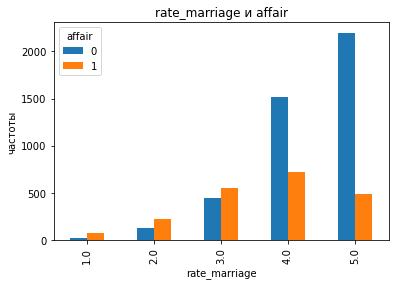

In [7]:
pd.crosstab(data.rate_marriage, data.affair).plot(kind = 'bar');
plt.title('rate_marriage и affair');
plt.xlabel('rate_marriage');
plt.ylabel('частоты');

Таблица сопряженности для affair и rate_marriage, в долях по столбцам. Доли измен выше, чем доли верности для оценок 1-2-3. Для оценок 4-5 доля измен ниже, чем верных.

In [8]:
print(pd.crosstab(data.affair, data.rate_marriage, normalize = 'columns').round(2))

rate_marriage   1.0   2.0   3.0   4.0   5.0
affair                                     
0              0.25  0.36  0.45  0.68  0.82
1              0.75  0.64  0.55  0.32  0.18


Таблица сопряженности, фактические частоты и теоретические (гипотеза независимости). В теоретическом распределении верность больше в каждой группе, а фактически это так только для оценок 1-2-3.

In [10]:
import statsmodels.api as sm

In [11]:
tab_rm = pd.crosstab(data.affair, data.rate_marriage)
table = sm.stats.Table(tab_rm)
print(table.table_orig)
print('')
print(table.fittedvalues.round())

rate_marriage  1.0  2.0  3.0   4.0   5.0
affair                                  
0               25  127  446  1518  2197
1               74  221  547   724   487

rate_marriage   1.0    2.0    3.0     4.0     5.0
affair                                           
0              67.0  236.0  673.0  1519.0  1818.0
1              32.0  112.0  320.0   723.0   866.0


Тест Хи-квадрат Пирсона на независимость affair и rate_marriage дает нулевое р-значение, то есть более чем достаточно аргументов для отвержения нулевой гипотезы о независимости.

In [12]:
stat, p, *_ = chi2_contingency(tab_rm, correction = False)
print('stat: ', stat.round(2), 'p-value: ', p)

stat:  718.84 p-value:  2.9045329481179437e-154


##### age

Больше всего женщин (74%) до 30 лет (значения 17.5, 22, 27), 26% 30-40 лет и 12% больше 40:

In [13]:
data.age.value_counts(normalize = True)

27.0    0.303
22.0    0.283
32.0    0.168
42.0    0.125
37.0    0.100
17.5    0.022
Name: age, dtype: float64

Во всех возрастах верности больше чем измен.

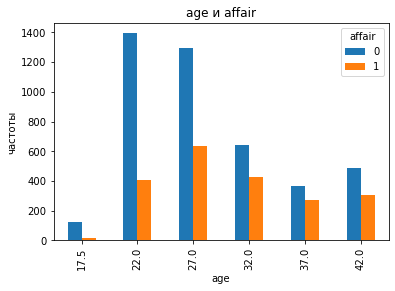

In [14]:
pd.crosstab(data.age, data.affair).plot(kind = 'bar');
plt.title('age и affair');
plt.xlabel('age');
plt.ylabel('частоты');

Таблица сопряженности для affair и age, в долях по столбцам. Доли измен ниже, чем верных.  Наиболее значительная разница для двух первых категорий возраста.

In [15]:
print(pd.crosstab(data.affair, data.age, normalize = 'columns').round(2))

age     17.5  22.0  27.0  32.0  37.0  42.0
affair                                    
0       0.91  0.77  0.67   0.6  0.57  0.61
1       0.09  0.23  0.33   0.4  0.43  0.39


Таблица сопряженности, фактические частоты и теоретические (гипотеза независимости). Частоты схожи для категорий 27, 32, 37, 42, так как там пропорции более менее ровные, около 60 на 40. А для первых двух категорий теоретические частоты измен выше.

In [16]:
tab_ag = pd.crosstab(data.affair, data.age)
table = sm.stats.Table(tab_ag)
print(table.table_orig)
print('')
print(table.fittedvalues.round())

age     17.5  22.0  27.0  32.0  37.0  42.0
affair                                    
0        126  1394  1298   644   364   487
1         13   406   633   425   270   306

age     17.5    22.0    27.0   32.0   37.0   42.0
affair                                           
0       94.0  1220.0  1308.0  724.0  430.0  537.0
1       45.0   580.0   623.0  345.0  204.0  256.0


Тест Хи-квадрат Пирсона на независимость affair и age дает нулевое р-значение, то есть более чем достаточно аргументов для отвержения нулевой гипотезы о независимости.

In [17]:
stat, p, *_ = chi2_contingency(tab_ag, correction = False)
print('stat: ', stat.round(2), 'p-value: ', p)

stat:  184.18 p-value:  6.840949774636419e-38


##### yrs_married

В браке 1-4 года 32% женщин, больше 10 лет и с детьми около 34% (значения 13, 16.5, 23):

In [18]:
data.yrs_married.value_counts(normalize = True)

2.5     0.320
6.0     0.179
16.5    0.128
23.0    0.127
9.0     0.095
13.0    0.093
0.5     0.058
Name: yrs_married, dtype: float64

Для всех категорий лет брака верности больще чем измен.

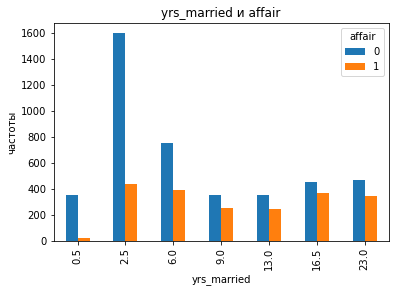

In [19]:
pd.crosstab(data.yrs_married, data.affair).plot(kind = 'bar');
plt.title('yrs_married и affair');
plt.xlabel('yrs_married');
plt.ylabel('частоты');

Таблица сопряженности для affair и yrs_married, в долях по столбцам. Для всех групп длительности доля измен ниже доли верности.  Наиболее значительная разница для двух первых категорий лет брака.

In [20]:
print(pd.crosstab(data.affair, data.yrs_married, normalize = 'columns').round(2))

yrs_married  0.5   2.5   6.0   9.0   13.0  16.5  23.0
affair                                               
0            0.96  0.78  0.66  0.58  0.59  0.55  0.57
1            0.04  0.22  0.34  0.42  0.41  0.45  0.43


Таблица сопряженности, фактические частоты и теоретические (гипотеза независимости). Для первых двух категорий теоретические частоты измен значительно выше фактических.

In [21]:
tab_ym = pd.crosstab(data.affair, data.yrs_married)
table = sm.stats.Table(tab_ym)
print(table.table_orig)
print('')
print(table.fittedvalues.round())

yrs_married  0.5   2.5   6.0   9.0   13.0  16.5  23.0
affair                                               
0             354  1595   754   348   347   449   466
1              16   439   387   254   243   369   345

yrs_married   0.5     2.5    6.0    9.0    13.0   16.5   23.0
affair                                                       
0            251.0  1378.0  773.0  408.0  400.0  554.0  549.0
1            119.0   656.0  368.0  194.0  190.0  264.0  262.0


Тест Хи-квадрат Пирсона на независимость affair и yrs_married дает нулевое р-значение, то есть более чем достаточно аргументов для отвержения нулевой гипотезы о независимости.

In [22]:
stat, p, *_ = chi2_contingency(tab_ym, correction = False)
print('stat: ', stat.round(2), 'p-value: ', p)

stat:  389.46 p-value:  5.159413266447153e-81


##### children

У 37% женщин детей нет, второй по частоте ответ 2 детей 23%, а один ребенок только у 18%:

In [23]:
data.children.value_counts(normalize = True)

0.0    0.379
2.0    0.233
1.0    0.182
3.0    0.123
4.0    0.052
5.5    0.032
Name: children, dtype: float64

Для всех категорий кол-ва детей верности больше чем измен. 

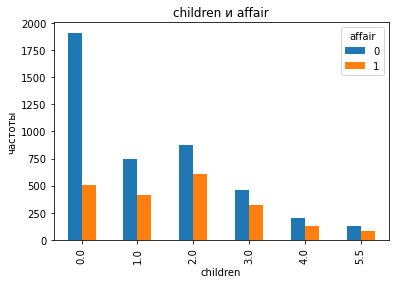

In [24]:
pd.crosstab(data.children, data.affair).plot(kind = 'bar');
plt.title('children и affair');
plt.xlabel('children');
plt.ylabel('частоты');

Таблица сопряженности для affair и children, в долях по столбцам. Для всех групп детей доля измен ниже доли верности. Наиболее значительная разница для отсутствия детей.

In [25]:
print(pd.crosstab(data.affair, data.children, normalize = 'columns').round(2))

children   0.0   1.0   2.0   3.0  4.0   5.5
affair                                     
0         0.79  0.64  0.59  0.59  0.6  0.61
1         0.21  0.36  0.41  0.41  0.4  0.39


Таблица сопряженности, фактические частоты и теоретические (гипотеза независимости). 

In [26]:
tab_c = pd.crosstab(data.affair, data.children)
table = sm.stats.Table(tab_c)
print(table.table_orig)
print('')
print(table.fittedvalues.round())

children   0.0  1.0  2.0  3.0  4.0  5.5
affair                                 
0         1912  747  873  460  197  124
1          502  412  608  321  131   79

children     0.0    1.0     2.0    3.0    4.0    5.5
affair                                              
0         1635.0  785.0  1003.0  529.0  222.0  138.0
1          779.0  374.0   478.0  252.0  106.0   65.0


Тест Хи-квадрат Пирсона на независимость affair и children дает нулевое р-значение, то есть более чем достаточно аргументов для отвержения нулевой гипотезы о независимости.

In [27]:
stat, p, *_ = chi2_contingency(tab_c, correction = False)
print('stat: ', stat.round(2), 'p-value: ', p)

stat:  244.27 p-value:  9.303019680004575e-51


##### religious

Средне религиозны 73% женщин (ответы 2-3), очень религиозны 10%, не религиозны 16%:

In [28]:
data.religious.value_counts(normalize = True)

3.0    0.380
2.0    0.356
1.0    0.160
4.0    0.103
Name: religious, dtype: float64

Для всех уровней религиозности верности больше чем измен. 

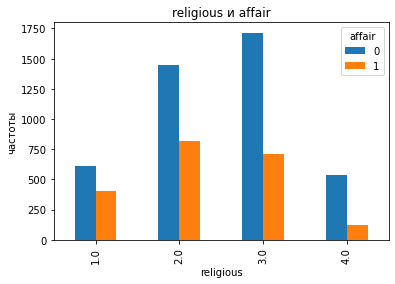

In [29]:
pd.crosstab(data.religious, data.affair).plot(kind = 'bar');
plt.title('religious и affair');
plt.xlabel('religious');
plt.ylabel('частоты');

Таблица сопряженности для affair и religious, в долях по столбцам. Для всех групп религиозности доля измен ниже доли верности. Наиболее значительная разница для очень религиозных.

In [30]:
print(pd.crosstab(data.affair, data.religious, normalize = 'columns').round(2))

religious  1.0   2.0   3.0   4.0
affair                          
0          0.6  0.64  0.71  0.82
1          0.4  0.36  0.29  0.18


Таблица сопряженности, фактические частоты и теоретические (гипотеза независимости).

In [31]:
tab_r = pd.crosstab(data.affair, data.religious)
table = sm.stats.Table(tab_r)
print(table.table_orig)

religious  1.0   2.0   3.0  4.0
affair                         
0          613  1448  1715  537
1          408   819   707  119


Тест Хи-квадрат Пирсона на независимость affair и religious дает нулевое р-значение, то есть более чем достаточно аргументов для отвержения нулевой гипотезы о независимости.

In [32]:
stat, p, *_ = chi2_contingency(tab_r, correction = False)
print('stat: ', stat.round(2), 'p-value: ', p)

stat:  113.53 p-value:  1.909881357296901e-24


##### educ

Только начальная школа меньше чем у 1% женщин. Высшая школа (без колледжа или частично) у 67%. Закончили колледж 17%.

In [33]:
data.educ.value_counts(normalize = True)

14.0    0.358
12.0    0.327
16.0    0.175
17.0    0.080
20.0    0.052
9.0     0.008
Name: educ, dtype: float64

Для всех уровней образования верности больше чем измен (для первой категории примерно равны). 

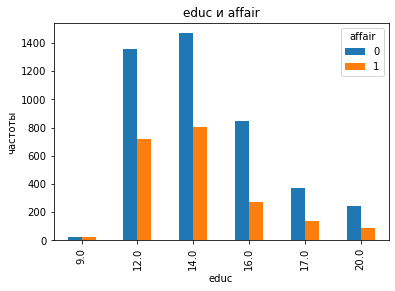

In [34]:
pd.crosstab(data.educ, data.affair).plot(kind = 'bar');
plt.title('educ и affair');
plt.xlabel('educ');
plt.ylabel('частоты');

Таблица сопряженности для affair и educ, в долях по столбцам. Для всех групп образования доля измен ниже доли верности.

In [35]:
print(pd.crosstab(data.affair, data.educ, normalize = 'columns').round(2))

educ    9.0   12.0  14.0  16.0  17.0  20.0
affair                                    
0       0.56  0.65  0.65  0.76  0.73  0.73
1       0.44  0.35  0.35  0.24  0.27  0.27


Таблица сопряженности, фактические частоты и теоретические (гипотеза независимости).

In [36]:
tab_e = pd.crosstab(data.affair, data.educ)
table = sm.stats.Table(tab_e)
print(table.table_orig)
print('')
print(table.fittedvalues.round())

educ    9.0   12.0  14.0  16.0  17.0  20.0
affair                                    
0         27  1361  1469   844   370   242
1         21   723   808   273   140    88

educ    9.0     12.0    14.0   16.0   17.0   20.0
affair                                           
0       33.0  1412.0  1543.0  757.0  346.0  224.0
1       15.0   672.0   734.0  360.0  164.0  106.0


Тест Хи-квадрат Пирсона на независимость affair и educ дает нулевое р-значение, то есть более чем достаточно аргументов для отвержения нулевой гипотезы о независимости.

In [37]:
stat, p, *_ = chi2_contingency(tab_e, correction = False)
print('stat: ', stat.round(2), 'p-value: ', p)

stat:  60.77 p-value:  8.428184255728632e-12


##### occupation

Белых воротничков 43%, управленческая деятельность у 11%:

In [38]:
data.occupation.value_counts(normalize = True)

3.0    0.437
4.0    0.288
2.0    0.135
5.0    0.116
6.0    0.017
1.0    0.006
Name: occupation, dtype: float64

Для всех категорий рода занятий верности больше чем измен. 

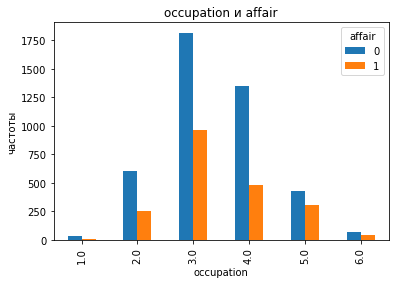

In [39]:
pd.crosstab(data.occupation, data.affair).plot(kind = 'bar');
plt.title('occupation и affair');
plt.xlabel('occupation');
plt.ylabel('частоты');

Таблица сопряженности для affair и occupation, в долях по столбцам. Для всех групп деятельности доля измен ниже доли верности. Наиболее значительная разница для первой категории.

In [40]:
print(pd.crosstab(data.affair, data.occupation, normalize = 'columns').round(2))

occupation   1.0   2.0   3.0   4.0   5.0   6.0
affair                                        
0           0.83  0.71  0.65  0.74  0.58  0.63
1           0.17  0.29  0.35  0.26  0.42  0.37


Таблица сопряженности, фактические частоты и теоретические (гипотеза независимости). 

In [41]:
tab_o = pd.crosstab(data.affair, data.occupation)
table = sm.stats.Table(tab_o)
print(table.table_orig)
print('')
print(table.fittedvalues.round())

occupation  1.0  2.0   3.0   4.0  5.0  6.0
affair                                    
0            34  607  1818  1354  431   69
1             7  252   965   480  309   40

occupation   1.0    2.0     3.0     4.0    5.0   6.0
affair                                              
0           28.0  582.0  1885.0  1243.0  501.0  74.0
1           13.0  277.0   898.0   591.0  239.0  35.0


Тест Хи-квадрат Пирсона на независимость affair и occupation дает нулевое р-значение, то есть более чем достаточно аргументов для отвержения нулевой гипотезы о независимости.

In [42]:
stat, p, *_ = chi2_contingency(tab_o, correction = False)
print('stat: ', stat.round(2), 'p-value: ', p)

stat:  77.75 p-value:  2.477892436591016e-15


##### occupation_husb

Мужей белых воротничков всего 7%, управленческая деятельность у 28%:

In [43]:
data.occupation_husb.value_counts(normalize = True)

4.0    0.319
5.0    0.279
2.0    0.205
6.0    0.083
3.0    0.077
1.0    0.036
Name: occupation_husb, dtype: float64

Для всех категорий рода деятельности мужей верности больше чем измен. 

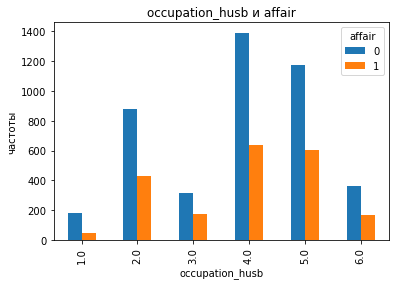

In [44]:
pd.crosstab(data.occupation_husb, data.affair).plot(kind = 'bar');
plt.title('occupation_husb и affair');
plt.xlabel('occupation_husb');
plt.ylabel('частоты');

Таблица сопряженности для affair и occupation_husb, в долях по столбцам. Для всех групп деятельности мужей доля измен ниже доли верности. Пропорции достаточно похожи между всеми группами.

In [45]:
print(pd.crosstab(data.affair, data.occupation_husb, normalize = 'columns').round(2))

occupation_husb   1.0   2.0   3.0   4.0   5.0   6.0
affair                                             
0                0.79  0.67  0.65  0.69  0.66  0.69
1                0.21  0.33  0.35  0.31  0.34  0.31


Таблица сопряженности, фактические частоты и теоретические (гипотеза независимости). 

In [46]:
tab_oh = pd.crosstab(data.affair, data.occupation_husb)
table = sm.stats.Table(tab_oh)
print(table.table_orig)
print('')
print(table.fittedvalues.round())

occupation_husb  1.0  2.0  3.0   4.0   5.0  6.0
affair                                         
0                181  882  317  1391  1177  365
1                 48  426  173   639   602  165

occupation_husb    1.0    2.0    3.0     4.0     5.0    6.0
affair                                                     
0                155.0  886.0  332.0  1375.0  1205.0  359.0
1                 74.0  422.0  158.0   655.0   574.0  171.0


Тест Хи-квадрат Пирсона на независимость affair и occupation_husb дает нулевое р-значение, то есть более чем достаточно аргументов для отвержения нулевой гипотезы о независимости.

In [47]:
stat, p, *_ = chi2_contingency(tab_oh, correction = False)
print('stat: ', stat.round(2), 'p-value: ', p)

stat:  18.43 p-value:  0.0024564278771048156


В итоге по всем факторам гипотеза о независимости с affair отвергнута, поэтому возьмем все факторы в модель.

<a href="#0"><h4>Наверх</h4></a>

<p id="2.2">
<h5>Подход 2</h5>

Выбор факторов по критерию mutual information, которая измеряет сокращение неопределенности для одной переменной при известном значении другой. Самый значимый фактор rate_marriage. Далее yrs_married, children, age и educ.

In [48]:
X = data[data.columns[:-1]]
y = data.affair

In [49]:
fs = SelectKBest(score_func = mutual_info_classif, k ='all')
fs.fit(X, y)
X_fs = fs.transform(X)
for i in list(data.columns[:-1]):
    print(f'{i}: {fs.scores_[list(data.columns[:-1]).index(i)].round(5)}')

rate_marriage: 0.05559
age: 0.01297
yrs_married: 0.03404
children: 0.02128
religious: 0.01872
educ: 0.0051
occupation: 0.00497
occupation_husb: 0.0


Второй вариант модели будет с пятью перечисленными выше факторами.

<p id="3">
<h4>Логистическая регрессия</h4>

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

Первая модель - все факторы.

* Делим датасет на трейн и тест. При этом используем параметр stratify, так как классы у нас не сбалансированы.
* Все факторы категориальные, но в числовом выражении и разного масштаба. Поэтому используем OrdinalEncoder, чтобы кодировка была в единой манере.
* Сначала проведем кросс-валидацию, чтобы оценить качество модели и сравнить с другой моделью.
* Считаем три метрики. Среднее и медианы очень близки. Accuracy 0.73, но эта метрика хороша для сбалансированных классов. Precision, среди определенных моделью как измена, фактических измен 63%. Recall, среди фактических измен модель нашла только 38%.

In [51]:
X = data[data.columns[:-1]]
y = data.affair

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify =  y, shuffle = True)

pipe = Pipeline( [ ("oe", OrdinalEncoder()), ("log", LogisticRegression())] )

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

scores_acc = cross_val_score(pipe, X_train, y_train, scoring = 'accuracy', cv = cv)
print('accuracy', 'среднее', round(np.mean(scores_acc),4), 'медиана', round(np.median(scores_acc),4))

scores_pr = cross_val_score(pipe, X_train, y_train, scoring = 'precision', cv = cv)
print('precision', 'среднее',  round(np.mean(scores_pr),4), 'медиана', round(np.median(scores_pr),4))

scores_re = cross_val_score(pipe, X_train, y_train, scoring = 'recall', cv = cv)
print('recall', 'среднее',  round(np.mean(scores_re),4), 'медиана', round(np.median(scores_re),4))

accuracy среднее 0.7303 медиана 0.7295
precision среднее 0.6365 медиана 0.6349
recall среднее 0.38 медиана 0.375


Вторая модель - факторы rate_marriage, yrs_married, children, age и educ.

Среднее и медианы метрик также очень близки. Accuracy 0.73, но эта метрика хороша для сбалансированных классов. Precision, среди определенных моделью как измена, фактических измен 63%. Recall, среди фактических измен модель нашла только 34%. По Recall вторая модель похуже. В задаче с прогнозом измен сложно оценить, цена какой ошибки выше: "не определить измену" (False Negative) или ложно определить измену (False Positive). Поэтому сложно выбрать на что опираться, на Precision или Recall.

In [52]:
X_2 = data[['rate_marriage', 'yrs_married', 'children', 'age', 'educ']]
y_2 = data.affair

X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2,
                                                            test_size = 0.3, random_state = 42,
                                                            stratify =  y_2, shuffle = True)
pipe_2 = Pipeline( [ ("oe", OrdinalEncoder()), ("log", LogisticRegression())] )

cv_2 = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

scores_acc_2 = cross_val_score(pipe_2, X_2_train, y_2_train, scoring = 'accuracy', cv = cv_2)
print('accuracy',  'среднее', round(np.mean(scores_acc_2),4), 'медиана', round(np.median(scores_acc_2),4))

scores_pr_2 = cross_val_score(pipe_2, X_2_train, y_2_train, scoring = 'precision', cv = cv_2)
print('precision',  'среднее', round(np.mean(scores_pr_2),4), 'медиана', round(np.median(scores_pr_2),4))

scores_re_2 = cross_val_score(pipe_2, X_2_train, y_2_train, scoring = 'recall', cv = cv_2)
print('recall',  'среднее', round(np.mean(scores_re_2),4), 'медиана', round(np.median(scores_re_2),4))

accuracy среднее 0.7249 медиана 0.7228
precision среднее 0.6371 медиана 0.6354
recall среднее 0.3421 медиана 0.3472


Выбираем первую модель. И теперь обучаем ее на всем трейне, кодируем категориальные факторы. По коэффициентам наиболее значимый фактор - rate_marriage, как и во втором подходе к отбору факторов. Наименее значимые children, educ, occupation_husb.

In [53]:
oe = OrdinalEncoder()
oe.fit(X_train)
X_train_enc = oe.transform(X_train)
X_test_enc = oe.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_enc, y_train)

list(zip(list(X_train.columns), lr.coef_[0].round(2)))

[('rate_marriage', -0.75),
 ('age', -0.39),
 ('yrs_married', 0.53),
 ('children', -0.05),
 ('religious', -0.38),
 ('educ', -0.05),
 ('occupation', 0.18),
 ('occupation_husb', 0.02)]

Доли измен в трейн и тест выборках такие же как во всем датасете, около 32%:

In [54]:
print(y_train.mean())
print(y_test.mean())

0.32248653500897667
0.3225130890052356


Делаем прогнозы на тестовой выборке. А также считаем вероятности, они понадобятся нам для построения кривых ниже. Метрики получились почти такие же как в кросс-валидации.

In [55]:
pred = lr.predict(X_test_enc)
prob_pred = lr.predict_proba(X_test_enc)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81      1294
           1       0.59      0.38      0.46       616

    accuracy                           0.72      1910
   macro avg       0.67      0.63      0.64      1910
weighted avg       0.70      0.72      0.70      1910



<a href="#0"><h4>Наверх</h4></a>

<p id="4">
<h4>ROC и PR кривые "вручную" и штатными средствами</h4>

Ручной алгоритм расчета для разных значений порога (отнесения к тому или иному классу по вероятности) TruePositiveRate и FalsePositiveRate для кривой ROC, Precision и Recall для кривой PR:

In [56]:
thresholds = np.linspace(0, 1, 100)

fpr_list = []
tpr_list = []
prec_list = []
rec_list = []
no_skill = y_test.mean()

for i in thresholds:
    tp = 0 
    fp = 0 
    fn = 0 
    tn = 0 
    
    for pred_prob, actual in zip( prob_pred[:, 1], y_test ):
        if pred_prob >= i:
            pred = 1
        else:
            pred = 0

        if pred == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1

        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1
                
    tpr = (tp) / (tp + fn) # также и recall
    fpr = (fp) / (fp + tn)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    
    try: # избежать деления на ноль
        prec = (tp) / (tp + fp)
        if prec > no_skill:
            prec_list.append(prec)
            rec_list.append(tpr)            
    except:
        pass


ROC кривая: <br>
* Каждая точка это пара значений TPR и FPR для конкретного значения порога
* TPR это то же самое что Recall - доля корректно определенных измен среди фактических измен
* FPR это доля некорректно определенных измен среди верности
* Чем меньше значение по Х тем меньше значения FP и выше TN.
* Чем больше значение по У тем выше TP и ниже FN.
* Построение кривой помогает понять трейд-офф для разных значений порога
* Считается приемлемой для сбалансированных классов, так как иначе она может давать слишком оптимистичную картину. В случае несбалансированных классов лучше использовать PR кривую. У нас измен около 32%, умеренная степень дисбаланса.
* Диагональ это генератор случайных чисел, то есть модель которая определяет класс случайным образом.
* На нашем графике кривая слева от генератора, значит лучше его. В идеале кривая должны стремиться к точке (0,1). У нас она где-то посередине между идеальной точкой и генератором.

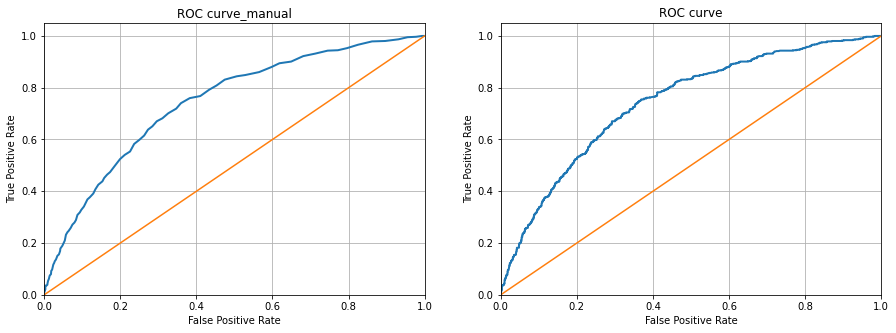

In [57]:
lw = 2
plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
plt.grid()
plt.plot(fpr_list, tpr_list, lw = lw, label = 'ROC curve ');
plt.plot([0, 1], [0, 1]);
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC curve_manual');

plt.subplot(1,2,2)
plt.grid()
lr_fpr, lr_tpr, __ = roc_curve(y_test, prob_pred[:, 1], pos_label=1)
plt.plot(lr_fpr, lr_tpr, lw = lw, label = 'ROC curve ');
plt.plot([0, 1], [0, 1]);
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC curve');

* Площадь под кривой помогает оценить качество модели в целом, без привязки к конкретному значению порога.
* У нас площадь около 0.74, неплохой показатель (площадь под случайным генератором - 0.5)

In [58]:
print('ROC-AUC_manual: ',round(auc( fpr_list, tpr_list ),4))
print('ROC-AUC: ',round(auc( lr_fpr, lr_tpr ),4))

ROC-AUC_manual:  0.7422
ROC-AUC:  0.7426


PR кривая:<br>
* Каждая точка это пара значений Recall и Precision для конкретного значения порога.
* Построение кривой помогает понять трейд-офф для разных значений порога
* Чем ниже порог, тем легче причисляют к категории 1: минимизируется FN и выше Recall (выше FP и ниже Precision).
* Чем выше порог, тем сложнее причисляют к категории 1, больше причисляют к категории 0: минимизируется FP и выше Precision (выше FN и ниже Recall).
* Пунктир это случайный классификатор.
* На нашем графика кривая выше него, значит лучше. Но идеальный случай это стремиться к точке (1,1), от этого наша кривая далековата.

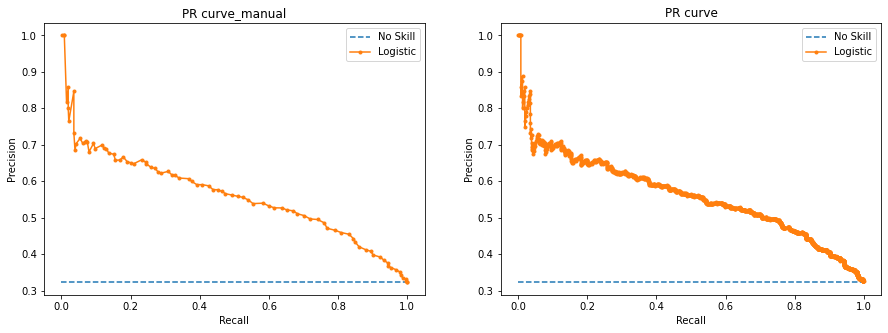

In [59]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill');
plt.plot(rec_list, prec_list, marker = '.', label = 'Logistic');
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.legend();
plt.title('PR curve_manual');

plt.subplot(1,2,2)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, prob_pred[:, 1])
plt.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill');
plt.plot(lr_recall, lr_precision, marker = '.', label = 'Logistic');
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.legend();
plt.title('PR curve');

* Площадь под кривой помогает оценить качество модели в целом, без привязки к конкретному значению порога.
* Наша площадь около 0.56 (против 0.3 для случайного), среднее качество.

In [60]:
print('Precision-Recall AUC_manual: ', round(auc(rec_list, prec_list),4))
print('Precision-Recall AUC: ', round(auc(lr_recall, lr_precision),4))

Precision-Recall AUC_manual:  0.56
Precision-Recall AUC:  0.5617


<a href="#0"><h4>Наверх</h4></a>